# A simple Client Credit Rating Model (Random Forest)

https://www.kaggle.com/datasets/satyajeetrai/credit-risk-dataset/data

Released under MIT License

Copyright (c) 2013 Mark Otto.

Copyright (c) 2017 Andrew Fong.

### Import Libraries

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve

### Load from BigQuery

In [15]:
from google.cloud import bigquery

# This works out of the box on Vertex AI Workbench
client = bigquery.Client()

# Run a query
query = """
SELECT * FROM `credit-risk-******.CreditData.csv`
LIMIT 1001
"""
df = client.query(query).to_dataframe()
df.head()

,id,Duration in months,Credit history,Purpose of the credit,Credit amount,Status of savings account_bonds,Present employment_years_,Installment rate in percentage of disposable income,personal_status,Other debtors _ guarantors,...,Property,Age in years,Other installment plans _banks_stores_,Housing,Number of existing credits at this bank,Job,Number of people being liable to provide maintenance for,Telephone,Foreign worker,Status of existing checking account
0,634,9,existing paid,furniture/equipment,1980,<100,<1,2,female div/dep/mar,co applicant,...,car,19,none,rent,2,skilled,1,none,True,bad
1,156,12,existing paid,furniture/equipment,1282,<100,1<=X<4,2,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,True,bad
2,297,12,existing paid,used car,4675,no known savings,<1,1,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,True,good
3,411,24,existing paid,radio/tv,1967,<100,>=7,4,female div/dep/mar,none,...,car,20,none,own,1,skilled,1,yes,True,good
4,421,15,existing paid,new car,3186,>=1000,4<=X<7,2,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,True,good


### Remove unuseful variables

In [16]:
df = df.drop(['id','Purpose of the credit','Other debtors _ guarantors','Number of people being liable to provide maintenance for'], axis=1)

### Prepare Data

In [17]:
# Target and features
target_column = 'Status of existing checking account'
y = df[target_column].map({'good': 1, 'bad': 0})
X = df.drop(columns=[target_column])

# Identify column types
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

### Run Random Forest Model

In [18]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred = rf_pipeline.predict(X_test)
y_prob = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"\n{'='*50}")
print("MODEL EVALUATION METRICS")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
if auc is not None:
    print(f"ROC AUC: {auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['bad', 'good']))


MODEL EVALUATION METRICS
Accuracy: 0.6900
F1 Score: 0.8075
ROC AUC: 0.7045

Classification Report:
              precision    recall  f1-score   support

         bad       0.44      0.13      0.21        30
        good       0.71      0.93      0.81        70

    accuracy                           0.69       100
   macro avg       0.58      0.53      0.51       100
weighted avg       0.63      0.69      0.63       100



### Show Confusion Matrx

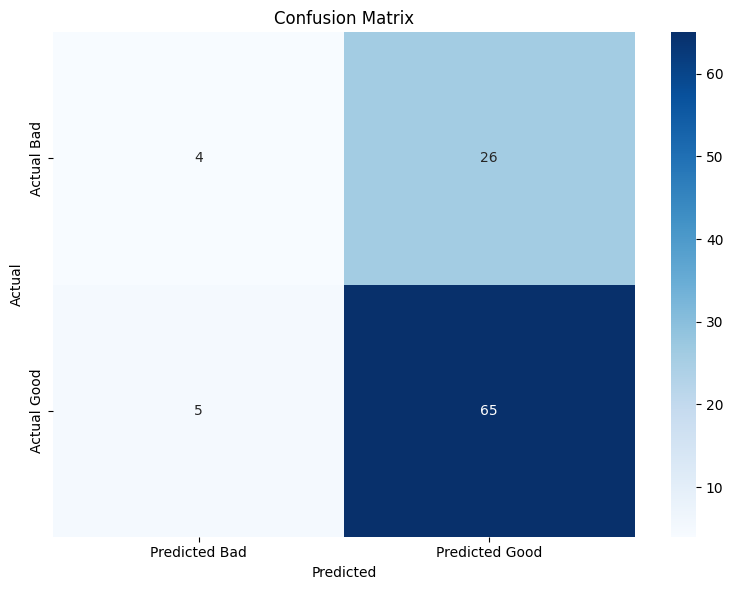

In [19]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Bad', 'Predicted Good'],
            yticklabels=['Actual Bad', 'Actual Good'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Show ROC Curve

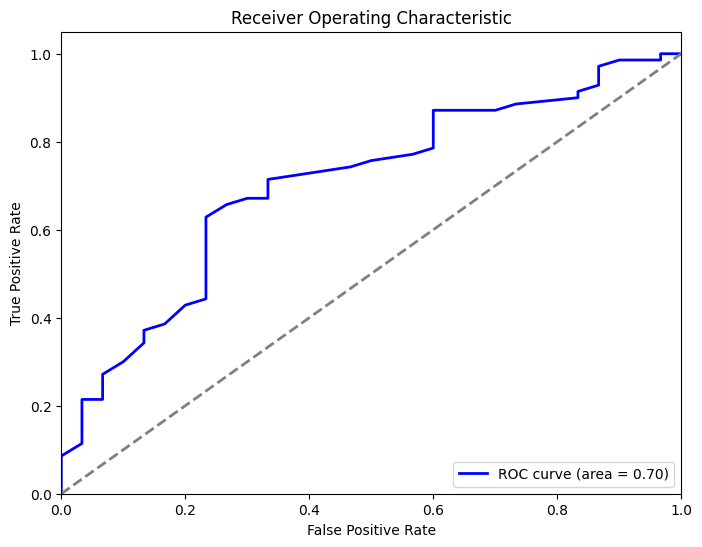

ROC AUC: 0.7045


In [20]:
# ROC curve
if auc is not None:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

### Analyse Most Important Predictors

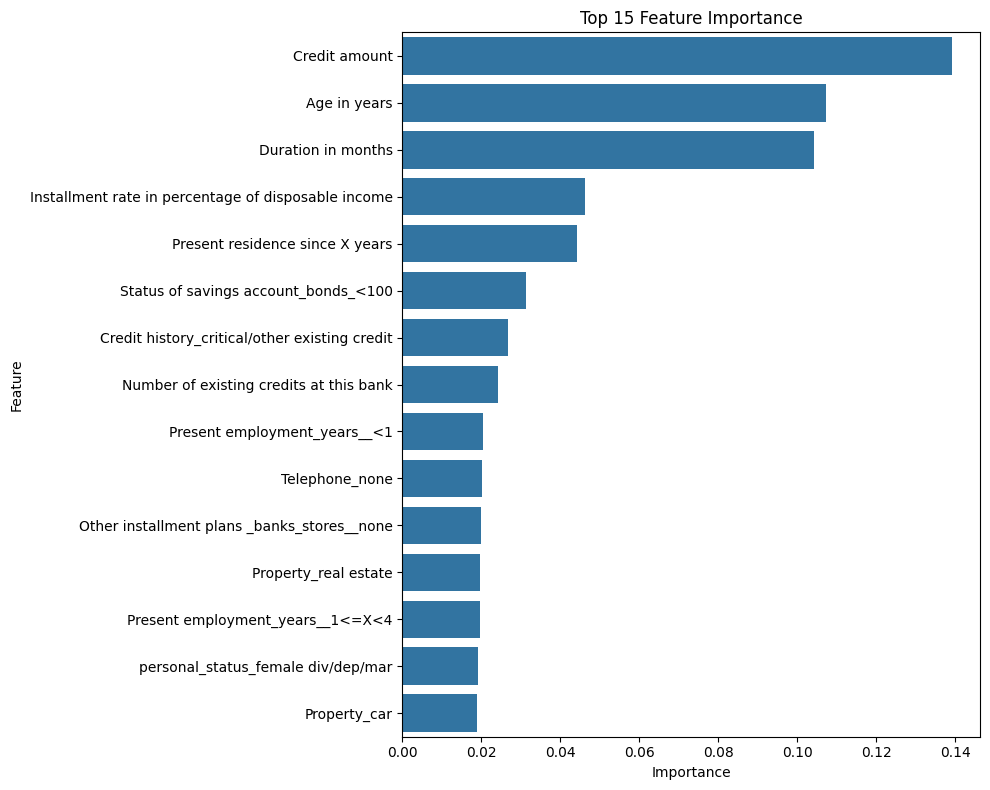

In [21]:
# Feature names after encoding
categorical_features = []
if categorical_cols:
    ohe = rf_pipeline.named_steps['preprocessor'].transformers_[1][1]
    categorical_features = ohe.get_feature_names_out(categorical_cols).tolist()
feature_names = numerical_cols + categorical_features

# Feature importance
importances = rf_pipeline.named_steps['classifier'].feature_importances_
if len(feature_names) == len(importances):
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
else:
    feature_importance = pd.DataFrame({
        'Feature': [f"Feature_{i}" for i in range(len(importances))],
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
# Plot feature importances
plt.figure(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

### Conclusions

Accuracy is better but recall is worse. Might be because of the small sample but in any case we move forward to XGBoost